## Importing Libraries

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import tensorflow as tf
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Providing Datapath of the mat files obtained from kaggle

In [ ]:
datapath = '/content/drive/MyDrive/archive_1/'
#https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset

## Defining Functions to load full and partial list of mat files

In [ ]:
def load_data_partial(filename):
    mat_contents = sio.loadmat(filename)
    return mat_contents

In [ ]:
def load_data(fileDir, exercise):
    word = exercise.lower()
    file_path_list = []
    valid_file_extensions = [".mat"]
    valid_file_extensions = [item.lower() for item in valid_file_extensions]


    for file in os.listdir(fileDir):
        extension = os.path.splitext(file)[1]
        if extension.lower() not in valid_file_extensions:
            continue
        file_path_list.append(os.path.join(fileDir, file))

    Data = []
    for path in file_path_list:
        base=os.path.basename(path)
        base = os.path.splitext(base)[0]
        if word in base:
            print(fileDir+'/%s'%(base))
            mat_contents = sio.loadmat(fileDir+'/%s'%(base))
            val = mat_contents['p']
            total_array = val[0,:] #assigning an array
            Data.append(total_array)

    return Data

### Loading the MAT files

In [ ]:
word = 'part'
total_data = load_data(datapath, word)
x =load_data_partial(datapath+str('part_1.mat'))

/content/drive/MyDrive/archive_1//part_1


## Feature Extraction: Extracting PPG ,ECG and ABP values from total_data

In [ ]:
PPG = []
ABP = []
ECG = []
for i in range((len(total_data))):
    for j in range(len(total_data[i])):
        k = len(total_data[i][j][0,:])
        for n in range(k//1000):
            ppg = (total_data[i][j][0,(n*1000):(n*1000)+1000]) # Extracting PPG values
            abp = (total_data[i][j][1,(n*1000):(n*1000)+1000]) #Extracting ABP values
            ecg = (total_data[i][j][2,(n*1000):(n*1000)+1000]) #Extracting ECG values
            PPG.append(ppg)
            ABP.append(abp)
            ECG.append(ecg)

# Converting list of PPG,ECG and ABP as array
PPG = np.asarray(PPG)
ABP = np.asarray(ABP)
ECG = np.asarray(ECG)



### Plotting graphs for PPG,ECG and ABP signals

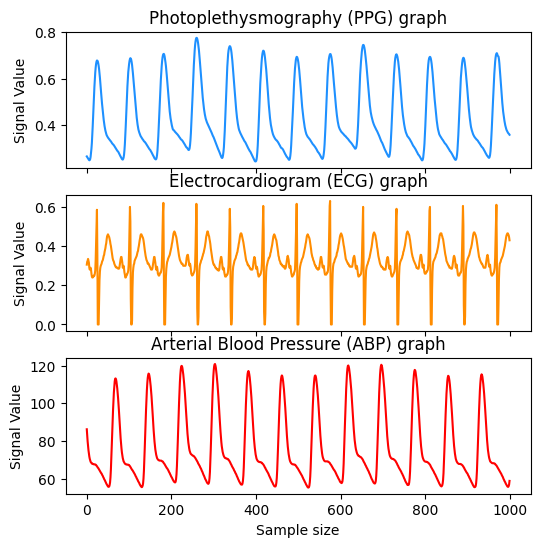

In [ ]:
# plotting sample  ppg, ecg and bp signals
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex=True)
y = 1000
ax[0].set_title('Photoplethysmography (PPG) graph', fontsize=12)
ax[0].set_ylabel('Signal Value')

ax[0].plot(PPG[y,:], c = 'dodgerblue')

ax[1].set_title('Electrocardiogram (ECG) graph', fontsize=12)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG[y,:], c='darkorange')

ax[2].set_title('Arterial Blood Pressure (ABP) graph', fontsize=12)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP[y,:], c = 'red')

### Correlation Estimation

In [ ]:
from scipy.stats import pearsonr

# Calculate the correlation between ECG and PPG signals
ecg_ppg_correlation, _ = pearsonr(ECG[:1000].flatten(), PPG[:1000].flatten())
print("Correlation between ECG and PPG signals:", ecg_ppg_correlation)

# Calculate the correlation between ECG and BP signals
ecg_bp_correlation, _ = pearsonr(ECG[:1000].flatten(), ABP[:1000].flatten())
print("Correlation between ECG and ABP signals:", ecg_bp_correlation)

# Calculate the correlation between PPG and BP signals
ppg_bp_correlation, _ = pearsonr(PPG[:1000].flatten(), ABP[:1000].flatten())
print("Correlation between PPG and ABP signals:", ppg_bp_correlation)

Correlation between ECG and PPG signals: -0.27346160018394666
Correlation between ECG and ABP signals: 0.059160138825351025
Correlation between PPG and ABP signals: -0.028087942051436457


## Splitting the data into 70% train and 30% test

**Input** : PPG values

**Output**:  ABP and ECG Values

In [ ]:
X_train_PPG, X_test_PPG, y_train_ABP, y_test_ABP, y_train_ECG, y_test_ECG = train_test_split(
    PPG, ABP, ECG, test_size=0.30)

In [ ]:
X_train_PPG_reshape = np.reshape(X_train_PPG, (X_train_PPG.shape[0], X_train_PPG.shape[1], 1))

In [ ]:
X_test_PPG_reshape =np.reshape(X_test_PPG, (X_test_PPG.shape[0] ,X_test_PPG.shape[1],1))

In [ ]:
input_shape = (X_train_PPG_reshape.shape[1],1)
inputs = Input(shape=input_shape)
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(32,return_sequences=False)(x)
# Branch 1 for BP output 1
bp_output = Dense(units=1000, activation='linear',name='bp_out')(x)
# Branch 2 for ECG output 2
ecg_output = Dense(units=1000, activation='tanh',name='ecg_out')(x)

lstm_model = Model(inputs=inputs, outputs=[bp_output, ecg_output])

In [ ]:
img_file = './model-research-LSTM.png'
tf.keras.utils.plot_model(lstm_model, to_file=img_file, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# optimizer = tf.keras.optimizers.SGD(lr=0.001)
lstm_model.compile(optimizer='adam',
              loss={'bp_out': tf.keras.losses.MeanAbsoluteError(), 'ecg_out': tf.keras.losses.MeanAbsoluteError()},
              metrics={'bp_out': tf.keras.metrics.RootMeanSquaredError(),
                       'ecg_out': tf.keras.metrics.RootMeanSquaredError()})
# es = EarlyStopping(monitor='BP_root_mean_squared_error',patience=5, min_delta=1e-3,mode='auto')
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 1000, 64)             16896     ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1000, 64)             0         ['lstm[0][0]']                
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   12416     ['dropout[0][0]']             
                                                                                              

In [ ]:
lstm_model_history = lstm_model.fit(X_train_PPG_reshape, [y_train_ABP, y_train_ECG],
               batch_size=1024,
               epochs=20,
               verbose = 1)

Epoch 1/20
22/22 [==============================] - 132s 6s/step - loss: 91.7046 - bp_out_loss: 91.2190 - ecg_out_loss: 0.4856 - bp_out_root_mean_squared_error: 95.5137 - ecg_out_root_mean_squared_error: 0.6077
Epoch 2/20
22/22 [==============================] - 121s 5s/step - loss: 90.8630 - bp_out_loss: 90.3938 - ecg_out_loss: 0.4691 - bp_out_root_mean_squared_error: 94.7266 - ecg_out_root_mean_squared_error: 0.6107
Epoch 3/20
22/22 [==============================] - 120s 5s/step - loss: 89.8733 - bp_out_loss: 89.4057 - ecg_out_loss: 0.4676 - bp_out_root_mean_squared_error: 93.7839 - ecg_out_root_mean_squared_error: 0.6061
Epoch 4/20
22/22 [==============================] - 119s 5s/step - loss: 88.9718 - bp_out_loss: 88.5045 - ecg_out_loss: 0.4672 - bp_out_root_mean_squared_error: 92.9251 - ecg_out_root_mean_squared_error: 0.6063
Epoch 5/20
22/22 [==============================] - 117s 5s/step - loss: 88.1256 - bp_out_loss: 87.6583 - ecg_out_loss: 0.4673 - bp_out_root_mean_squared_er

### Evaluating LSTM Model without normalised ABP values

In [ ]:
#Predicting on the test set using the LSTM model
LSTM_predictions = lstm_model.predict(X_test_PPG_reshape)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ABP, LSTM_predictions[0])
print(f'LSTM Model RMSE for ABP: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ABP, LSTM_predictions[0])
print(f'LSTM Model MAE for ABP: {MAE.result().numpy()}')

301/301 [==============================] - 55s 182ms/step
LSTM Model RMSE for ABP: 80.95405578613281
LSTM Model MAE for ABP: 75.83109283447266


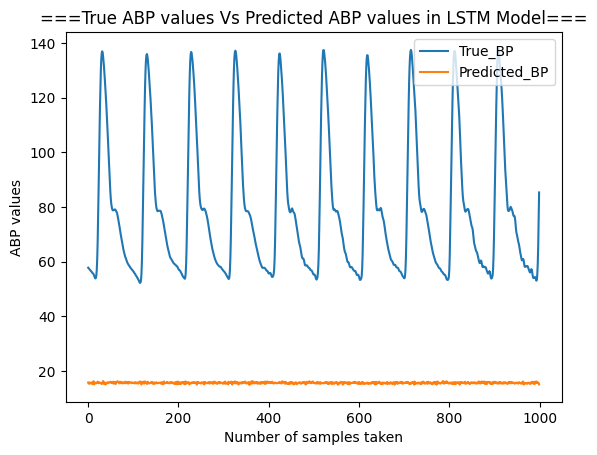

In [ ]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ABP values Vs Predicted ABP values in LSTM Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('ABP values')
plt.plot(y_test_ABP[1000]) #only plotting 100 samples
plt.plot(LSTM_predictions[0][1000])
plt.legend(['True_BP', 'Predicted_BP'])

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ECG, LSTM_predictions[1])
print(f'LSTM Model RMSE for Non-Normalized ECG: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ECG, LSTM_predictions[1])
print(f'LSTM Model MAE for Non-Normalized ECG: {MAE.result().numpy()}')

LSTM Model RMSE for Non-Normalized ECG: 0.5958898663520813
LSTM Model MAE for Non-Normalized ECG: 0.46115171909332275


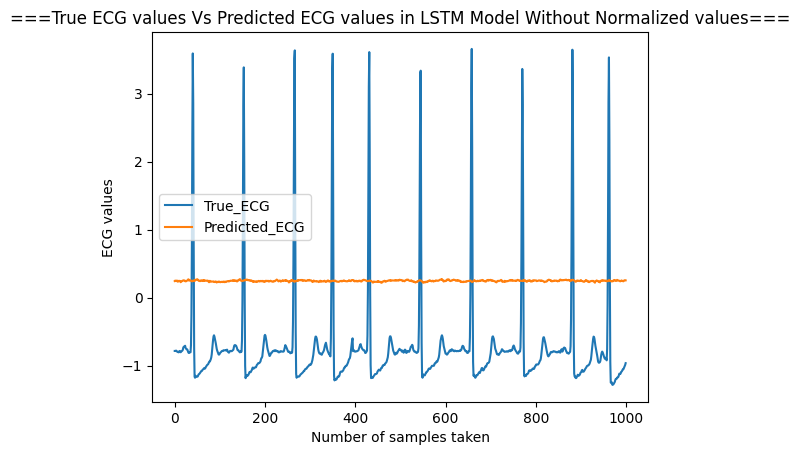

In [ ]:
# Visualize predicted ECG and the True ECG for LSTM model
plt.title("===True ECG values Vs Predicted ECG values in LSTM Model Without Normalized values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ECG values')
plt.plot(y_test_ECG[5]) #only plotting 100 samples
plt.plot(LSTM_predictions[1][5])
plt.legend(['True_ECG', 'Predicted_ECG'])

## Defining Function to Normalize the PPG and ABP values

In [ ]:
def normalise(x):
    normalised = (x-min(x))/(max(x)-min(x))
    return normalised

def scale_abp(x):
    normalised = x/200
    return normalised

def normalise_abp(abp, x_max, x_min):
    normalised = (abp-x_min)/(x_max-x_min)
    return normalised

def abp_maxmin_value(x):
    max_x = []
    min_x = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            max_x.append(max(x[i][j][1,:]))
            min_x.append(min(x[i][j][1,:]))
    x_max = max(max_x)
    x_min = min(min_x)
    return x_max, x_min

### Checking Minimum and Maximum values in total_data

In [ ]:
x_max, x_min = abp_maxmin_value(total_data)
print(x_max, x_min)
x_max = 200.0
x_min = 50.0

199.90934525391145 50.01623903864891


## Feature Extraction and Feature Scaling: Extracting PPG ,ECG and ABP values from total_data and normalizing them

In [ ]:
# #Data Pre-processing
# # Extracting signal data Feature-extraction
PPG_N = []
ABP_N = []
ECG_N = []
i=0
for j in range(len(total_data[i])):
    k = len(total_data[i][j][0,:])
    for n in range(k//1000):
        ppg_n = normalise(total_data[i][j][0,(n*1000):(n*1000)+1000])
        abp_n = normalise_abp(total_data[i][j][1,(n*1000):(n*1000)+1000], x_max, x_min)
        ecg_n = normalise(total_data[i][j][2,(n*1000):(n*1000)+1000])
        PPG_N.append(ppg_n)
        ABP_N.append(abp_n)
        ECG_N.append(ecg_n)

PPG_N = np.asarray(PPG_N)
ABP_N = np.asarray(ABP_N)
ECG_N = np.asarray(ECG_N)

### Plotting graphs for Normalized PPG,ECG and ABP signals

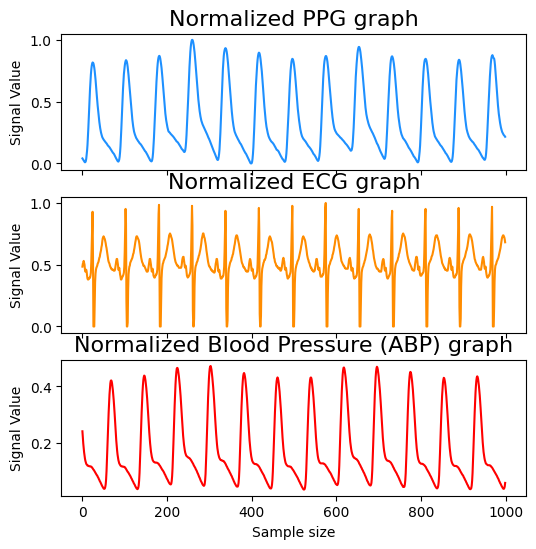

In [ ]:
# ##plotting sample normalized ppg, ecg and bp signals
# ##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(6,6), sharex=True)
y = 1000
ax[0].set_title('Normalized PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(PPG_N[y,:], c = 'dodgerblue')

ax[1].set_title('Normalized ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG_N[y,:], c='darkorange')

ax[2].set_title('Normalized Blood Pressure (ABP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP_N[y,:], c = 'red')

In [ ]:
from scipy.stats import pearsonr

# Calculate the correlation between ECG and PPG signals
ecg_ppg_correlation, _ = pearsonr(ECG_N.flatten(), PPG_N.flatten())
print("Correlation between ECG and PPG signals:", ecg_ppg_correlation)

# Calculate the correlation between ECG and BP signals
ecg_bp_correlation, _ = pearsonr(ECG_N.flatten(), ABP_N.flatten())
print("Correlation between ECG and BP signals:", ecg_bp_correlation)

# Calculate the correlation between PPG and BP signals
ppg_bp_correlation, _ = pearsonr(PPG_N.flatten(), ABP_N.flatten())
print("Correlation between PPG and BP signals:", ppg_bp_correlation)

Correlation between ECG and PPG signals: 0.08773596049540383
Correlation between ECG and BP signals: -0.00745494163158836
Correlation between PPG and BP signals: -0.30653244540364794


## Splitting the normalized data into 70% train and 30% test
**Input** : *Normalized PPG values*

**Output**: *Normalized ABP & ECG values*

In [ ]:
# creating train and val sets
# X_train, X_test, y_train, y_test = train_test_split(PPG_N, ABP_N, test_size=0.30)

In [ ]:
X_train_PPG_N, X_test_PPG_N, y_train_ABP_N, y_test_ABP_N, y_train_ECG_N, y_test_ECG_N = train_test_split(
    PPG_N, ABP_N, ECG_N, test_size=0.30)

## LSTM Model

### Reshaping the X_train and X_test values for LSTM model
The input to a LSTM model should be 3D(Sample Size, Time Step and Number of Features). Hence reshaping X_train and X_test to match the required input dimension.

In [ ]:
X_train_PPG_N_reshape = np.reshape(X_train_PPG_N, (X_train_PPG_N.shape[0], X_train_PPG_N.shape[1], 1))

In [ ]:
X_test_PPG_N_reshape =np.reshape(X_test_PPG_N, (X_test_PPG_N.shape[0] ,X_test_PPG_N.shape[1],1))

### Training LSTM model with normalised signal values

In [ ]:
lstm_model_history_N = lstm_model.fit(X_train_PPG_N_reshape, [y_train_ABP_N, y_train_ECG_N],
               batch_size=1024,
               epochs=20,
               verbose = 1)

Epoch 1/20
22/22 [==============================] - 118s 5s/step - loss: 15.4673 - bp_out_loss: 15.3288 - ecg_out_loss: 0.1385 - bp_out_root_mean_squared_error: 15.3321 - ecg_out_root_mean_squared_error: 0.2015
Epoch 2/20
22/22 [==============================] - 118s 5s/step - loss: 14.9487 - bp_out_loss: 14.8123 - ecg_out_loss: 0.1364 - bp_out_root_mean_squared_error: 14.8168 - ecg_out_root_mean_squared_error: 0.2000
Epoch 3/20
22/22 [==============================] - 118s 5s/step - loss: 14.2302 - bp_out_loss: 14.0940 - ecg_out_loss: 0.1361 - bp_out_root_mean_squared_error: 14.0990 - ecg_out_root_mean_squared_error: 0.1997
Epoch 4/20
22/22 [==============================] - 118s 5s/step - loss: 13.4928 - bp_out_loss: 13.3566 - ecg_out_loss: 0.1362 - bp_out_root_mean_squared_error: 13.3618 - ecg_out_root_mean_squared_error: 0.1998
Epoch 5/20
22/22 [==============================] - 118s 5s/step - loss: 12.7540 - bp_out_loss: 12.6179 - ecg_out_loss: 0.1361 - bp_out_root_mean_squared_er

### Evaluating LSTM Model with normalised ABP values

In [ ]:
#Predicting on the test set using the LSTM model
LSTM_predictions_N = lstm_model.predict(X_test_PPG_N_reshape)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ABP_N, LSTM_predictions_N[0])
print(f'LSTM Model RMSE for Normalized ABP: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ABP_N, LSTM_predictions_N[0])
print(f'LSTM Model MAE for Normalized ABP: {MAE.result().numpy()}')

301/301 [==============================] - 55s 183ms/step
LSTM Model RMSE for Normalized ABP: 0.19930455088615417
LSTM Model MAE for Normalized ABP: 0.1477876752614975


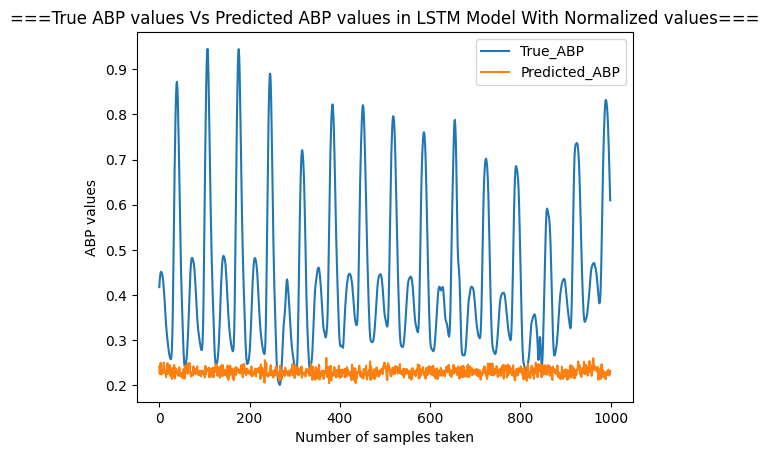

In [ ]:
  # Visualize predicted BP and the True BP for LSTM model
plt.title("===True ABP values Vs Predicted ABP values in LSTM Model With Normalized values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ABP values')
# plt.plot(y_lstm_N_sb[1000]) #only plotting 100 samples
# plt.plot(LSTM_pred_N_sb[1000])
plt.plot(y_test_ABP_N[1000]) #only plotting 100 samples
plt.plot(LSTM_predictions_N[0][1000])
plt.legend(['True_ABP', 'Predicted_ABP'])

### Evaluating LSTM model with normalized ECG Values

In [ ]:

rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ECG_N, LSTM_predictions_N[1])
print(f'LSTM Model RMSE for Normalized ECG: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ECG_N, LSTM_predictions_N[1])
print(f'LSTM Model MAE for Normalized ECG: {MAE.result().numpy()}')

LSTM Model RMSE for Normalized ECG: 0.19743390381336212
LSTM Model MAE for Normalized ECG: 0.13377279043197632


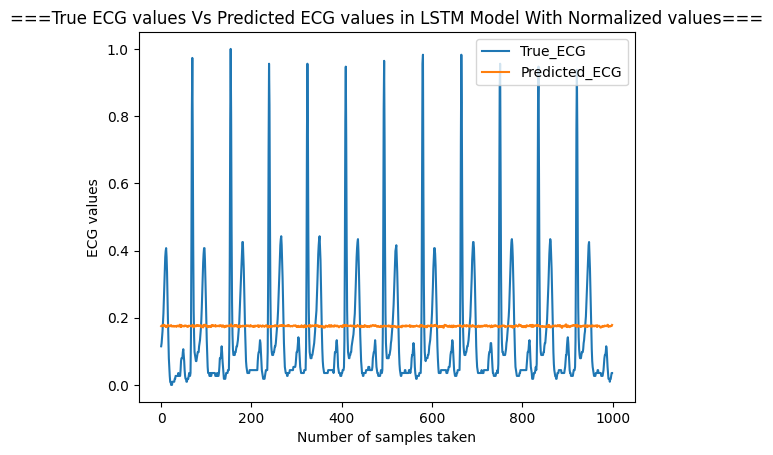

In [ ]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ECG values Vs Predicted ECG values in LSTM Model With Normalized values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ECG values')
plt.plot(y_test_ECG_N[5]) #only plotting 100 samples
plt.plot(LSTM_predictions_N[1][5])
plt.legend(['True_ECG', 'Predicted_ECG'])

### LSTM Model with data augmentation

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x, y1, y2, batch_size=32, shuffle=True):
        self.x = x
        self.y1 = y1
        self.y2 = y2
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(x))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch = self.x[batch_indexes]
        y1_batch = self.y1[batch_indexes]
        y2_batch = self.y2[batch_indexes]


        return x_batch, [y1_batch, y2_batch]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
new_ppg= PPG_N.reshape((PPG_N.shape[0],PPG_N.shape[1],1))
new_ppg.shape

(32061, 1000, 1)

In [ ]:
train_generator = DataGenerator(new_ppg, ABP_N, ECG_N, batch_size=1024)
validation_generator = DataGenerator(new_ppg, ABP_N, ECG_N, batch_size=1024, shuffle=False)

lstm_model.fit(train_generator,
          validation_data=validation_generator,
          epochs=20,
          steps_per_epoch=len(train_generator),
          validation_steps=len(validation_generator))

Epoch 1/20
32/32 [==============================] - 266s 8s/step - loss: 0.2846 - bp_out_loss: 0.1490 - ecg_out_loss: 0.1356 - bp_out_root_mean_squared_error: 0.1983 - ecg_out_root_mean_squared_error: 0.1991 - val_loss: 0.2831 - val_bp_out_loss: 0.1477 - val_ecg_out_loss: 0.1354 - val_bp_out_root_mean_squared_error: 0.1992 - val_ecg_out_root_mean_squared_error: 0.1998
Epoch 2/20
32/32 [==============================] - 263s 8s/step - loss: 0.2843 - bp_out_loss: 0.1487 - ecg_out_loss: 0.1356 - bp_out_root_mean_squared_error: 0.1979 - ecg_out_root_mean_squared_error: 0.1995 - val_loss: 0.2830 - val_bp_out_loss: 0.1476 - val_ecg_out_loss: 0.1354 - val_bp_out_root_mean_squared_error: 0.1987 - val_ecg_out_root_mean_squared_error: 0.1994
Epoch 3/20
32/32 [==============================] - 263s 8s/step - loss: 0.2840 - bp_out_loss: 0.1485 - ecg_out_loss: 0.1355 - bp_out_root_mean_squared_error: 0.1976 - ecg_out_root_mean_squared_error: 0.1994 - val_loss: 0.2829 - val_bp_out_loss: 0.1476 - val

### Evaluating LSTM model with Augmented signal Values for ABP

In [ ]:
#Predicting on the test set using the LSTM model
LSTM_predictions_augment = lstm_model.predict(X_test_PPG_N_reshape)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ABP_N, LSTM_predictions_augment[0])
print(f'LSTM Model RMSE for Augmented ABP: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ABP_N, LSTM_predictions_augment[0])
print(f'LSTM Model MAE for Augented ABP: {MAE.result().numpy()}')

301/301 [==============================] - 51s 170ms/step
LSTM Model RMSE for Augmented ABP: 0.19796249270439148
LSTM Model MAE for Augented ABP: 0.1474618762731552


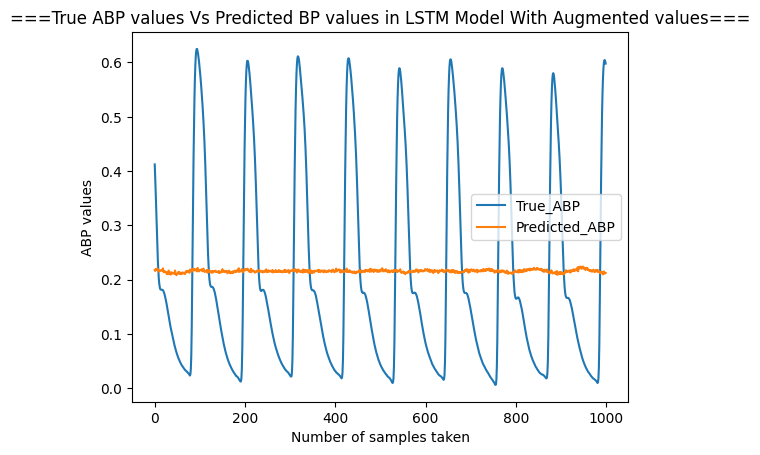

In [ ]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ABP values Vs Predicted BP values in LSTM Model With Augmented values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ABP values')
plt.plot(y_test_ABP_N[1000]) #only plotting 100 samples
plt.plot(LSTM_predictions_augment[0][1000])
plt.legend(['True_ABP', 'Predicted_ABP'])

### Evaluating LSTM model with Augmented ECG values

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test_ECG_N, LSTM_predictions_augment[1])
print(f'LSTM Model RMSE for Augmented ECG: {rmse.result().numpy()}')

# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test_ECG_N, LSTM_predictions_augment[1])
print(f'LSTM Model MAE for Augmented ECG: {MAE.result().numpy()}')

LSTM Model RMSE for Augmented ECG: 0.19694431126117706
LSTM Model MAE for Augmented ECG: 0.13377532362937927


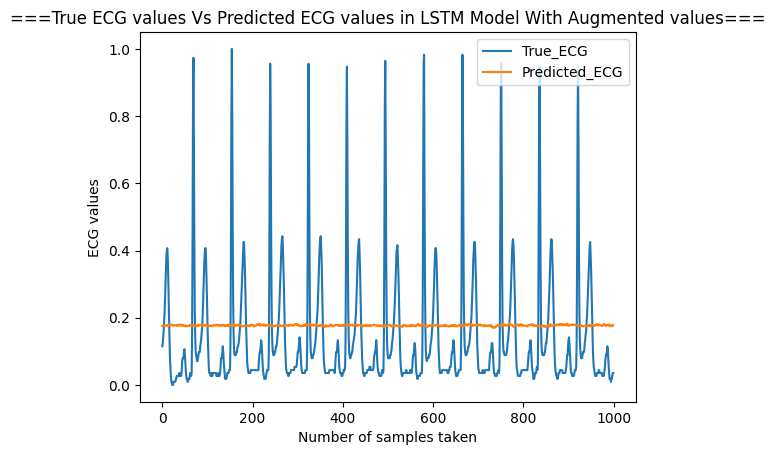

In [ ]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True ECG values Vs Predicted ECG values in LSTM Model With Augmented values===")
plt.xlabel('Number of samples taken')
plt.ylabel('ECG values')
plt.plot(y_test_ECG_N[5]) #only plotting 100 samples
plt.plot(LSTM_predictions_augment[1][5])
plt.legend(['True_ECG', 'Predicted_ECG'])